In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
data = pd.read_csv('TCS_1h.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

**Feature Engineering**

In [5]:
def feature_engineering(data):
    # Technical Indicators
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['SMA_50'] = data['close'].rolling(window=50).mean()
    data['RSI'] = 100 - (100 / (1 + (data['close'].diff().clip(lower=0).rolling(window=14).mean() /
                                      data['close'].diff().clip(upper=0).abs().rolling(window=14).mean())))
    data['MACD'] = data['close'].ewm(span=12, adjust=False).mean() - data['close'].ewm(span=26, adjust=False).mean()
    data['Bollinger_High'] = data['close'].rolling(window=20).mean() + (data['close'].rolling(window=20).std() * 2)
    data['Bollinger_Low'] = data['close'].rolling(window=20).mean() - (data['close'].rolling(window=20).std() * 2)


In [7]:
# Price Action Features
data['High_Low'] = data['high'] - data['low']
data['Momentum'] = data['close'].diff(4)
data['Volatility'] = data['close'].rolling(window=20).std()


In [9]:
# Statistical Features
data['Rolling_Mean'] = data['close'].rolling(window=10).mean()
data['Rolling_Var'] = data['close'].rolling(window=10).var()
data['Rolling_Skew'] = data['close'].rolling(window=10).skew()
data['Rolling_Kurt'] = data['close'].rolling(window=10).kurt()

In [11]:
# Lagged Features
for lag in range(1, 6):
    data[f'Lag_{lag}'] = data['close'].shift(lag)


In [31]:
  data.dropna(inplace=True)
    return data
data = feature_engineering(data)


IndentationError: unexpected indent (198138263.py, line 2)

In [19]:
# 2. Normalization and Standardization
features = data.drop(columns=['close'])  # Keep 'close' as target
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), index=features.index, columns=features.columns)
target = np.where(data['close'].shift(-1) > data['close'], 1, 0)  # Predict if next day close will be higher or not

In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, shuffle=False)

In [22]:
# 3. Model Training and Backtesting
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Backtest predictions
preds = model.predict(X_test)
data.loc[X_test.index, 'pred_signal'] = preds
data['pred_signal'].fillna(0, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_1292\3672396530.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['pred_signal'].fillna(0, inplace=True)


In [33]:
# Calculate returns based on predictions
data['strategy_returns'] = data['pred_signal'].shift(1) * data['close'].pct_change()
data['cumulative_returns'] = (1 + data['strategy_returns']).cumprod() - 1
data['buy_hold_returns'] = (1 + data['close'].pct_change()).cumprod() - 1


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


In [34]:
# Performance Metrics
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
sharpe_ratio = (data['strategy_returns'].mean() / data['strategy_returns'].std()) * np.sqrt(252)
max_drawdown = (data['cumulative_returns'].cummax() - data['cumulative_returns']).max()


In [35]:
# Results Summary
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")

Accuracy: 0.51
Precision: 0.52
Recall: 0.45
Sharpe Ratio: 0.11
Max Drawdown: 0.11


In [36]:
# 4. Validation and Out-of-Sample Testing
# Split data further for validation
X_train_in, X_valid, y_train_in, y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)


In [37]:
# Re-train and test on validation data
model.fit(X_train_in, y_train_in)
val_preds = model.predict(X_valid)
val_accuracy = accuracy_score(y_valid, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 0.50


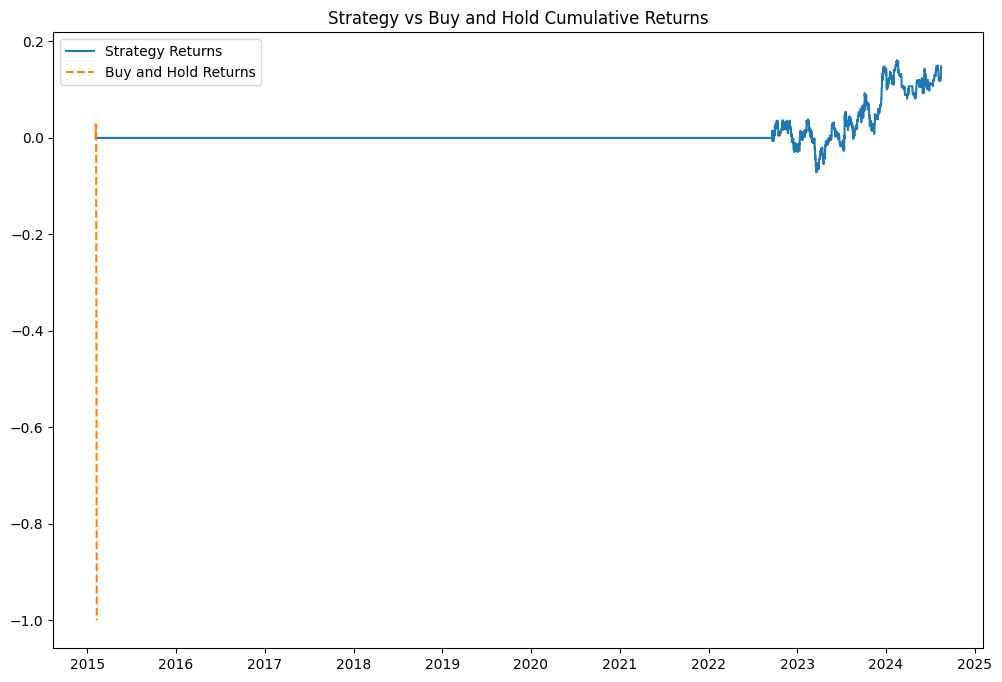

In [38]:
# 5. Final Strategy and Visualization
plt.figure(figsize=(12, 8))
plt.plot(data['cumulative_returns'], label='Strategy Returns')
plt.plot(data['buy_hold_returns'], label='Buy and Hold Returns', linestyle='--')
plt.legend()
plt.title('Strategy vs Buy and Hold Cumulative Returns')
plt.show()

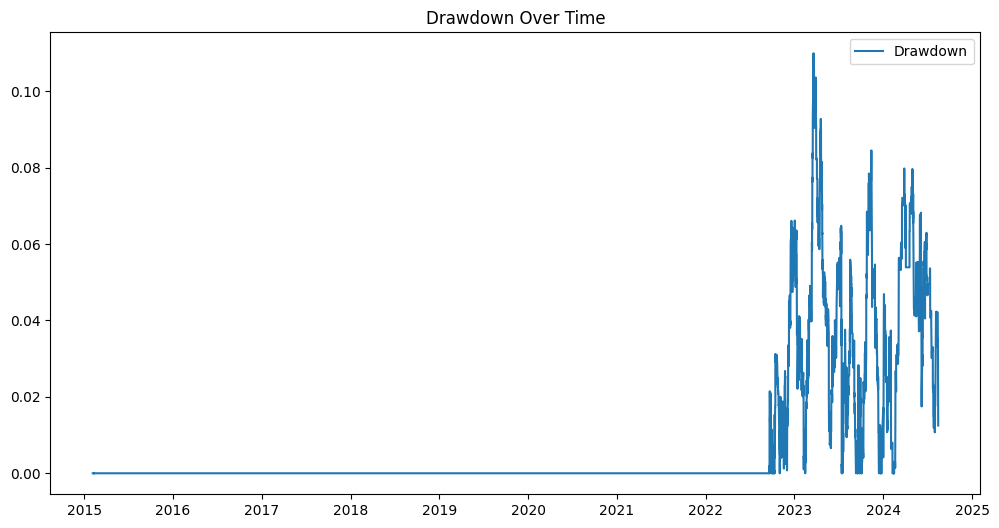

In [39]:
# Drawdown Chart
plt.figure(figsize=(12, 6))
data['drawdown'] = data['cumulative_returns'].cummax() - data['cumulative_returns']
plt.plot(data['drawdown'], label='Drawdown')
plt.title('Drawdown Over Time')
plt.legend()
plt.show()


In [41]:
# Equity Curve (Final Tear Sheet)
print("\nFinal Performance Summary:")
print(f"Cumulative Returns: {data['cumulative_returns'].iloc[-1]:.2f}")
print(f"Buy and Hold Cumulative Returns: {data['buy_hold_returns'].iloc[-1]:.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


Final Performance Summary:
Cumulative Returns: 0.15
Buy and Hold Cumulative Returns: nan
Confusion Matrix:
 [[925 703]
 [914 747]]


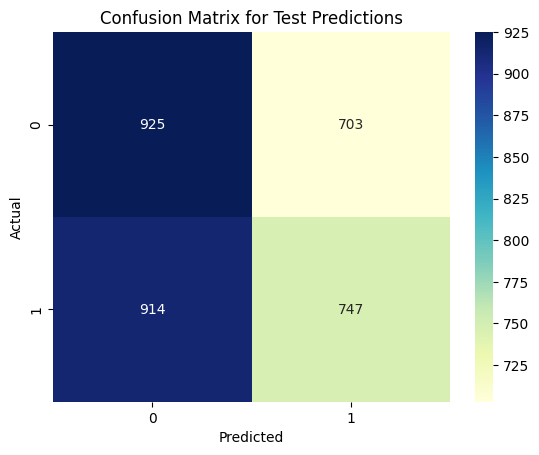

In [42]:
# Show confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Predictions')
plt.show()